# Global thresholding on pre-GLOF NDWI images

In [124]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

### Show NDWI input image

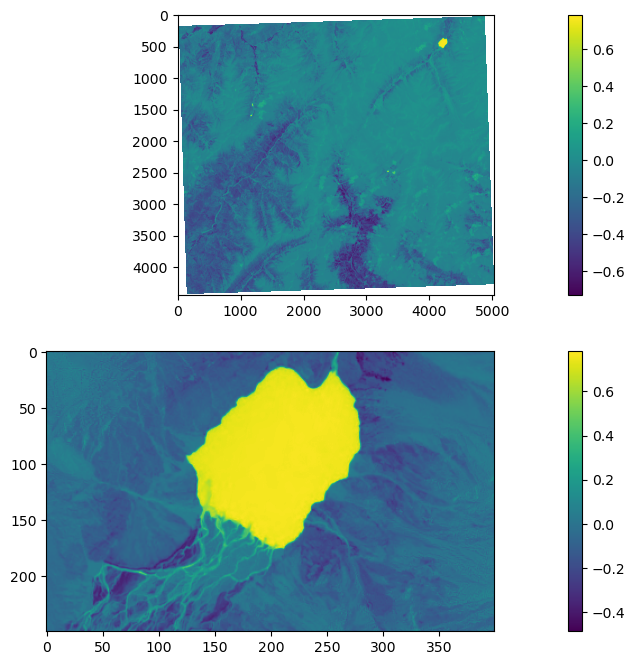

In [173]:
path='/home/crs2/Downloads/'
filename='NDWI20190628T055641.tif'
src = rasterio.open(path+filename)
array = src.read(1)

fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,figsize=(19,8))
img1=ax.imshow(array)
img2=ax1.imshow(array[350:600,4000:4400])
fig.colorbar(img1, ax=ax)
fig.colorbar(img2, ax=ax1)

### Some functions:
- Some of them required to tile the large image into subtiles
- Some others required for the thresholding itself

In [174]:
def tile_vars(image, selection='Martinis', t_method=['KI', 'Otsu'], tile_dim=[200, 200], hand_matrix=None,
              directory_figures=None, accuracy=200, incomplete_tile_warning=True):
    """ Calculate tile variables
    
    Inputs:
    image: nd array
        Array of pixel values.
    selection: str (default='Martinis')
        Method for tile selection. Currently only option is 'Martinis'.
    t_method: list (default=['KI', 'Otsu'])
        List of thresholds to calculate. Should contain one or both of "KI", "Otsu".
    tile_dim: list (default=[200, 200])
        Dimension of tiles.
    hand_matrix: ndarray or None (default=None)
        Array of HAND values.
    incomplete_tile_warning: bool (default=True)
        Whether to give a warning when incomplete tiles are encountered.
    Outputs:
    tile_ki: nd array
        Array of KI thresholds.
    tile_o: nd array
        Array of Otsu thresholds.
    average: nd array
        Array of tile averages.
    stdev: nd array
        Array of tiled st. devs.
    hand: nd array
        Array of tile mean HAND values.
    """
    tile_rows, tile_cols = tile_dim
    nrt = np.ceil(image.shape[0]/tile_rows).astype('int')
    nct = np.ceil(image.shape[1]/tile_cols).astype('int')
    if selection == 'Martinis':
        stdev = np.full([nrt, nct], np.nan)
        average = np.full([nrt, nct], np.nan)
    elif selection == 'Chini':
        a = np.full([nrt, nct], np.nan)
        bc = np.full([nrt, nct], np.nan)
        sr = np.full([nrt, nct], np.nan)
    if hand_matrix is not None:
        hand = np.full([nrt, nct], np.nan)
    else:
        hand = None
    for r in np.arange(0, image.shape[0], tile_rows):
        tile_rindex = np.floor(r/tile_rows).astype('int')
        for c in np.arange(0, image.shape[1], tile_cols):
            tile_cindex = np.floor(c/tile_cols).astype('int')
            tile = image[r:min(r+tile_rows, image.shape[0]), c:min(c+tile_cols, image.shape[1])]
            if np.sum(np.isnan(tile)) <= 0.1*np.size(tile):
                if selection == 'Martinis':
                    tr, tc = tile.shape
                    mu1 = np.nanmean(tile[0:tr//2, 0:tc//2])
                    mu2 = np.nanmean(tile[0:tr//2, tc//2:])
                    mu3 = np.nanmean(tile[tr//2:, 0:tc//2])
                    mu4 = np.nanmean(tile[tr//2:, tc//2:])
                    stdev[tile_rindex, tile_cindex] = np.std([mu1, mu2, mu3, mu4]) 
                    average[tile_rindex, tile_cindex] = np.nanmean(tile)
                elif selection == 'Chini':
                    if tile[np.isnan(tile)].size / tile.size < 0.1:
                        if directory_figures:
                            fig_filename = os.path.join(directory_figures, "Tile{}-{}_HistFitting.png".format(
                                tile_rindex, tile_cindex))
                        else:
                            fig_filename = None
                        try:
                            x, y = get_hist(tile[~np.isnan(tile)], accuracy=accuracy)
                            par_dist = fit_two_gaussians(x, y, apply_otsu(tile, accuracy=accuracy),
                                                         fig_filename=fig_filename)
                            a[tile_rindex, tile_cindex] = get_ashman(par_dist[1], par_dist[2], par_dist[4], par_dist[5])
                            bc[tile_rindex, tile_cindex] = get_bc(x, y, par_dist)
                            sr[tile_rindex, tile_cindex] = get_sr(*par_dist)
                        except:
                            a[tile_rindex, tile_cindex] = np.nan
                            bc[tile_rindex, tile_cindex] = np.nan
                            sr[tile_rindex, tile_cindex] = np.nan
                if hand_matrix is not None:
                    hand[tile_rindex, tile_cindex] = np.nanmean(hand_matrix[r:min(r+tile_rows, image.shape[0]),
                                                                c:min(c+tile_cols, image.shape[1])])
            elif incomplete_tile_warning:
                print("Tile ({0:.0f}, {1:.0f}) is incomplete.".format(tile_rindex, tile_cindex))
    if selection == "Martinis":
        return (average, stdev), hand
    elif selection == "Chini":
        return (a, bc, sr), hand
    else:
        return None, hand  # TODO: modify for other selection methods

def Kittler_Illingworth(im,accuracy):
    """
    The reimplementation of Kittler-Illingworth Thresholding algorithm by Bob Pepin
    Works on 8-bit images only
    Original Matlab code: https://www.mathworks.com/matlabcentral/fileexchange/45685-kittler-illingworth-thresholding
    Paper: Kittler, J. & Illingworth, J. Minimum error thresholding. Pattern Recognit. 19, 4147 (1986).
    """
   # h,g = np.histogram(im.ravel(),256,[0,256])
    image = im[~np.isnan(im)]
    image = image[image>0]
    image = image[image<0.2]
    ######
    h, g = np.histogram(image, bins=accuracy, density=True)
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p =  c / c[-1]
    v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - p*np.log(p) - (1-p)*np.log(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    # out[:,:] = 0
    # out[im >= t] = 255
    return t

def apply_otsu(image, accuracy=200, fig_filename=None):
    """Select threshold according to Otsu
    
    Inputs:
    image: nd array
        Array of pixel values.
    accuracy: int(default=200)
        Number of bins to construct histogram.
    fig_filename: str or None (default=None)
        If not None, a plot of the between-class variance is saved to the specified path
    Outputs:
    t: float
        Threshold value
    """
    if not isinstance(image, np.ndarray):
        image = np.asarray(image)
    # Histogram
    ###### Modified by Cristian to exclude outliers ...
    image = image[~np.isnan(image)]
    image = image[image>0]
    image = image[image<0.2]
    ######
    h, bin_edges = np.histogram(image, bins=accuracy, density=True)
    bin_width = bin_edges[1]-bin_edges[0]
    g = np.arange(bin_edges[0]+bin_width/2.0, bin_edges[-1], bin_width)
    # Between class variance and threshold
    w1 = np.cumsum(h)
    w2 = w1[-1] - w1
    w2[w2 == 0] = 1e-9
    gh = np.cumsum(g*h)
    mu1 = gh/w1
    mu2 = (gh[-1]-gh)/w2
    var_between = w1*w2*(mu1-mu2)**2
    idx = np.nanargmax(var_between)
    t = g[idx]
    # Plot
    if fig_filename:
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(g, var_between, color='k')
        ax[0].plot([t, t], [ax[0].get_ylim()[0], np.nanmax(var_between)], 'r')
        ax[1].bar(g, h)
        ax[1].plot([t, t], [0, np.nanmax(h)], 'r')
        plt.savefig(fig_filename)
        plt.close(fig)
    # Return
    return t

def tiled_thresholding(image, selection='Martinis', t_method=['KI', 'Otsu'], tile_dim=[200, 200], n_final=5,
                       hand_matrix=None, hand_t=100, directory_figures=None, accuracy=200, incomplete_tile_warning=True):
    """ Apply tiled thresholding: Adapted from Lisa Lnduyt's paper
    
    Inputs:
    image: nd array
        Array of pixel values.
    selection: str (default='Martinis')
        Method for tile selection. Currently only option is 'Martinis'.
    t_method: list (default=['KI', 'Otsu'])
        List of thresholds to calculate. Should contain one or both of "KI", "Otsu".
    tile_dim: list (default=[200, 200])
        Dimension of tiles.
    n_final: int (default=5)
        Number of tiles to select.
    hand_matrix: ndarray or None (default=None)
        Array of HAND values.
    hand_t: float (default=100)
        Maximum HAND value allowed for threshold selection.
    directory_figures: str or None (default=None)
        If not None, figure is saved to specified directory.
    incomplete_tile_warning: bool (default=True)
        Whether to give a warning when incomplete tiles are encountered.
    Outputs:
    tile_ki: nd array
        Array of KI thresholds.
    tile_o: nd array
        Array of Otsu thresholds.
    average: nd array
        Array of tile averages.
    stdev: nd array
        Array of tiled st. devs.
    hand: nd array
        Array of tile mean HAND values.
    """
    tile_dim = np.array(tile_dim)
    if selection == "Martinis":
        # Tile image and compute stats per tile 
        (average, stdev), hand = tile_vars(image, selection=selection, t_method=t_method, tile_dim=tile_dim,
                                           accuracy=accuracy, hand_matrix=hand_matrix,
                                           directory_figures=directory_figures,
                                           incomplete_tile_warning=incomplete_tile_warning)
       #%
        # fig,ax=plt.subplots()
        # ax.imshow(average,cmap='jet')
        
        # fig,ax=plt.subplots()
        # ax.imshow(stdev,cmap='jet')
        #%
        q = np.nanpercentile(stdev, 95)
        stdev[average > np.nanmean(average)] = np.nan
        if hand_matrix:
            stdev[hand > hand_t] = np.nan
        i_r, i_c = np.where(stdev > q)  # select tiles with stdev > 95-percentile
        #%
        while len(i_r) == 0:
            tile_dim = tile_dim//2
            print('Tile dimensions halved.')
            (average, stdev), hand = tile_vars(image, selection=selection, t_method=t_method, tile_dim=tile_dim, 
                                               accuracy=accuracy, hand_matrix=hand_matrix,
                                               directory_figures=directory_figures,
                                               incomplete_tile_warning=incomplete_tile_warning)
            q = np.percentile(stdev, 95)
            i_r, i_c = np.where(stdev > q)
        #%
        sorted_indices = np.argsort(stdev[i_r, i_c])[::-1]
        i_r = i_r[sorted_indices]
        i_c = i_c[sorted_indices]
        #%
        # Tile threshold values
        tile_ki = []
        tile_o = []
        for tile_rindex, tile_cindex in zip(i_r, i_c):
            tile = image[tile_rindex * tile_dim[0]:min((tile_rindex + 1) * tile_dim[0], image.shape[0]),
                         tile_cindex * tile_dim[1]:min((tile_cindex + 1) * tile_dim[1], image.shape[1])]
            #if directory_figures:
            #fig, ax = plt.subplots()
            #ax.imshow(tile, cmap="gray", vmin=0, vmax=0.04)
            #plt.savefig(os.path.join(directory_figures, "Tile{}-{}_image.png".format(tile_rindex, tile_cindex)))
            #plt.close(fig)
            if "KI" in t_method:
                if directory_figures:
                    fig_filename = os.path.join(directory_figures, "Tile{}-{}_KI.png".format(tile_rindex, tile_cindex))
                else:
                    fig_filename = None
                tile_ki.append(Kittler_Illingworth(tile,accuracy))
            if "Otsu" in t_method:
                if directory_figures:
                    fig_filename = os.path.join(directory_figures, "Tile{}-{}_Otsu.png".format(tile_rindex, tile_cindex))
                else:
                    fig_filename = None
                tile_o.append(apply_otsu(tile, accuracy=accuracy, fig_filename=fig_filename)) # append the threshold for each tile
        #%
        tile_ki = np.array(tile_ki)
        tile_o = np.array(tile_o)
        i_r = i_r[~np.isnan(tile_ki)]
        i_c = i_c[~np.isnan(tile_ki)]
        tile_o = tile_o[~np.isnan(tile_ki)]
        tile_ki = tile_ki[~np.isnan(tile_ki)]
        if i_r.size > n_final:
            tile_selection = [i_r[:n_final], i_c[:n_final]]
            tile_ki = tile_ki[:n_final]
            tile_o = tile_o[:n_final]
        else:
            tile_selection = [i_r, i_c]
       
        # Global threshold and quality indicator
        if 'KI' in t_method:
            t_ki = np.mean(tile_ki)
            s = np.std(tile_ki)
            #if s > 5: # dB
            if s > 3.17:
                print('Histogram merge necessary for KI.')
                pixel_selection = np.empty(0)
                for tile_rindex, tile_cindex in zip(tile_selection[0], tile_selection[1]):
                    tile = image[tile_rindex*tile_dim[0]:min((tile_rindex+1)*tile_dim[0], image.shape[0]),
                                 tile_cindex*tile_dim[1]:min((tile_cindex+1)*tile_dim[1], image.shape[1])]
                    pixel_selection = np.append(pixel_selection, tile.ravel())
                    del tile
                t_ki = Kittler_Illingworth(pixel_selection, accuracy=accuracy)
        if 'Otsu' in t_method:
            t_otsu = np.mean(tile_o)
            s = np.std(tile_o)
            #if s > 5:
            if s > 3.17:
                print('Histogram merge necessary for Otsu.')
                pixel_selection = np.empty(0)
                for tile_rindex, tile_cindex in zip(tile_selection[0], tile_selection[1]):
                    tile = image[tile_rindex*tile_dim[0]:min((tile_rindex+1)*tile_dim[0], image.shape[0]),
                                 tile_cindex*tile_dim[1]:min((tile_cindex+1)*tile_dim[1], image.shape[1])]
                    pixel_selection = np.append(pixel_selection, tile.ravel())
                    del tile
                t_otsu = apply_otsu(pixel_selection, accuracy=accuracy)                
    # elif selection == "Chini":
    #     # Tile properties and selection
    #     (a, bc, sr), hand = tile_vars(image, selection=selection, t_method=t_method,
    #                                                      tile_dim=tile_dim, accuracy=accuracy,
    #                                                      hand_matrix=hand_matrix, directory_figures=directory_figures,
    #                                                      incomplete_tile_warning=incomplete_tile_warning)
    #     tile_selection = np.array(np.where((a > 2) & (bc > 0.99) & (sr > 0.1)))
    #     # Global threshold value
    #     pixel_selection = np.empty(0)
    #     for tile_rindex, tile_cindex in zip(tile_selection[0], tile_selection[1]):
    #         tile = image[tile_rindex * tile_dim[0]:min((tile_rindex + 1) * tile_dim[0], image.shape[0]),
    #                      tile_cindex * tile_dim[1]:min((tile_cindex + 1) * tile_dim[1], image.shape[1])]
    #         pixel_selection = np.append(pixel_selection, tile.ravel())
    #         del tile
    #     if 'KI' in t_method:
    #         t_ki = Kittler_Illingworth(pixel_selection, accuracy=accuracy)
    #     if "Otsu" in t_method:
    #         t_otsu = apply_otsu(pixel_selection, accuracy=accuracy)  
        return (t_ki, t_otsu, tile_selection)

### Run the algorithm

In [175]:
Tilling_Method='Martinis'
thr_methods=['Otsu','KI']

In [176]:
t_NDWI_KI, t_NDWI_otsu, tile_selection = tiled_thresholding((array), selection=Tilling_Method, t_method=thr_methods, tile_dim=[200, 200], n_final=5,
                               hand_matrix=None, hand_t=100, directory_figures=None, accuracy=200, incomplete_tile_warning=True)

Tile (0, 0) is incomplete.
Tile (0, 1) is incomplete.
Tile (0, 2) is incomplete.
Tile (0, 3) is incomplete.
Tile (0, 4) is incomplete.
Tile (0, 5) is incomplete.
Tile (0, 6) is incomplete.
Tile (0, 7) is incomplete.
Tile (0, 8) is incomplete.
Tile (0, 9) is incomplete.
Tile (0, 10) is incomplete.
Tile (0, 11) is incomplete.
Tile (0, 12) is incomplete.
Tile (0, 13) is incomplete.
Tile (0, 14) is incomplete.
Tile (0, 15) is incomplete.
Tile (0, 16) is incomplete.
Tile (0, 17) is incomplete.
Tile (0, 18) is incomplete.
Tile (0, 19) is incomplete.
Tile (0, 20) is incomplete.
Tile (0, 21) is incomplete.
Tile (0, 24) is incomplete.
Tile (0, 25) is incomplete.
Tile (1, 24) is incomplete.
Tile (1, 25) is incomplete.
Tile (2, 24) is incomplete.
Tile (2, 25) is incomplete.
Tile (3, 24) is incomplete.
Tile (3, 25) is incomplete.
Tile (4, 0) is incomplete.
Tile (4, 24) is incomplete.
Tile (4, 25) is incomplete.
Tile (5, 0) is incomplete.
Tile (5, 24) is incomplete.
Tile (5, 25) is incomplete.
Tile

/home/crs2/anaconda3/envs/WTD_py37/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/crs2/anaconda3/envs/WTD_py37/lib/python3.7/site-packages/ipykernel_launcher.py:102: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/crs2/anaconda3/envs/WTD_py37/lib/python3.7/site-packages/ipykernel

## Apply mask based on the determined threshold and plot: 20190628

Global threshold based on K&I algorithm: 0.0920797411352396
Global threshold based on Otsu algorithm: 0.07716936451615766


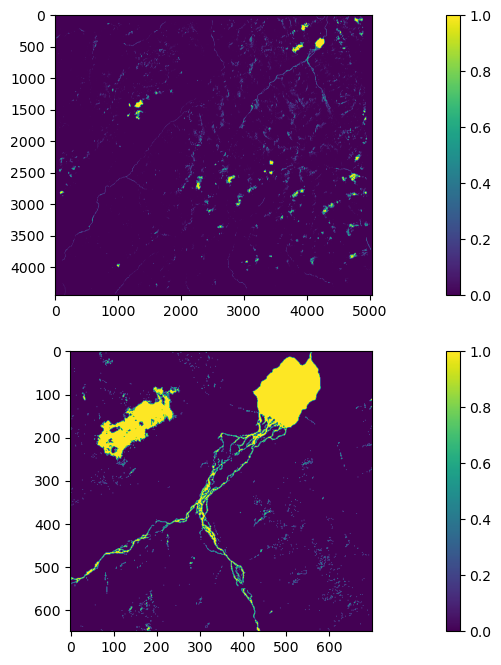

In [177]:
flood_px = ((array) > t_NDWI_otsu)# & (pw_px == 0) 
print('Global threshold based on K&I algorithm: '+str(t_NDWI_KI))
print('Global threshold based on Otsu algorithm: '+str(t_NDWI_otsu))


fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,figsize=(19,8))
img1=ax.imshow(flood_px)
img2=ax1.imshow(flood_px[350:1000,3700:4400])
fig.colorbar(img1, ax=ax)
fig.colorbar(img2, ax=ax1)

## Other examples: 20190703

In [179]:
filename='NDWI20190703T055649.tif'
src = rasterio.open(path+filename)
array1 = src.read(1)

In [180]:
# t_NDWI_KI, t_NDWI_otsu, tile_selection = tiled_thresholding((array), selection=Tilling_Method, t_method=thr_methods, tile_dim=[200, 200], n_final=5,
#                                hand_matrix=None, hand_t=100, directory_figures=None, accuracy=200, incomplete_tile_warning=True)

Global threshold based on K&I algorithm: 0.0920797411352396
Global threshold based on Otsu algorithm: 0.07716936451615766


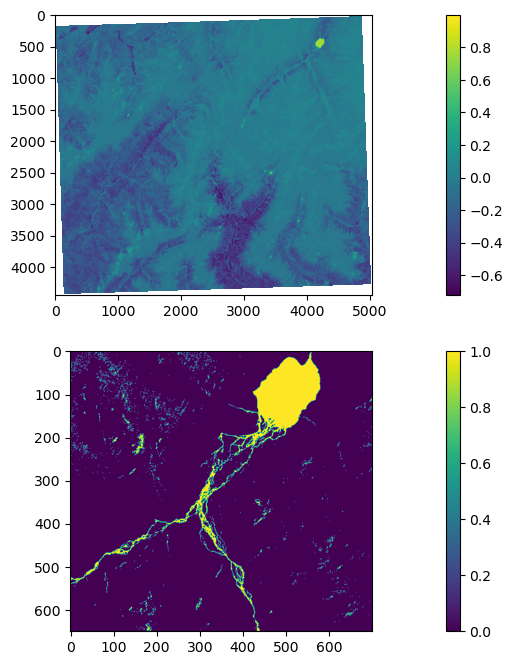

In [181]:
flood_px1 = ((array1) > t_NDWI_otsu)# & (pw_px == 0) 
print('Global threshold based on K&I algorithm: '+str(t_NDWI_KI))
print('Global threshold based on Otsu algorithm: '+str(t_NDWI_otsu))

fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,figsize=(19,8))
img1=ax.imshow(array1)
#img2=ax1.imshow(flood_px)
img2=ax1.imshow(flood_px1[350:1000,3700:4400])
fig.colorbar(img1, ax=ax)
fig.colorbar(img2, ax=ax1)

## 20200627

In [153]:
filename='NDWI20200627T055639.tif'
src = rasterio.open(path+filename)
array2 = src.read(1)

In [154]:
# t_NDWI_KI, t_NDWI_otsu, tile_selection = tiled_thresholding((array), selection=Tilling_Method, t_method=thr_methods, tile_dim=[200, 200], n_final=5,
#                                hand_matrix=None, hand_t=100, directory_figures=None, accuracy=200, incomplete_tile_warning=True)

Global threshold based on K&I algorithm: 0.0920797411352396
Global threshold based on Otsu algorithm: 0.07716936451615766


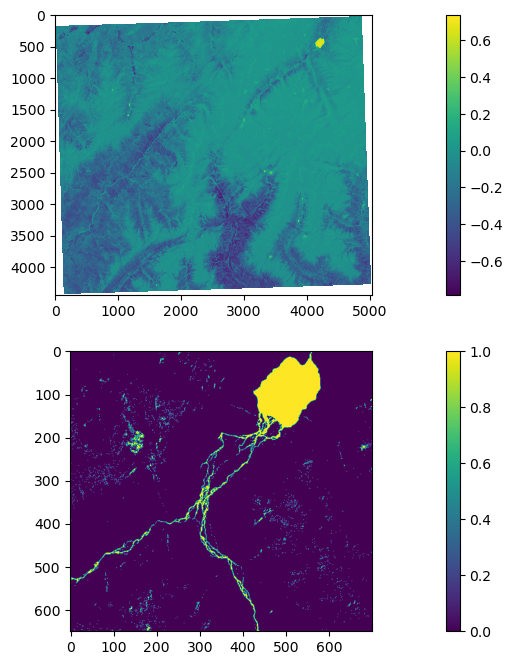

In [182]:
flood_px2 = ((array2) > t_NDWI_otsu)# & (pw_px == 0) 
print('Global threshold based on K&I algorithm: '+str(t_NDWI_KI))
print('Global threshold based on Otsu algorithm: '+str(t_NDWI_otsu))

fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,figsize=(19,8))
img1=ax.imshow(array2)
#img2=ax1.imshow(flood_px)
img2=ax1.imshow(flood_px2[350:1000,3700:4400])
fig.colorbar(img1, ax=ax)
fig.colorbar(img2, ax=ax1)

## 20200702

In [184]:
filename='NDWI20200702T055641.tif'
src = rasterio.open(path+filename)
array3 = src.read(1)

In [185]:
# t_NDWI_KI, t_NDWI_otsu, tile_selection = tiled_thresholding((array), selection=Tilling_Method, t_method=thr_methods, tile_dim=[200, 200], n_final=5,
#                                hand_matrix=None, hand_t=100, directory_figures=None, accuracy=200, incomplete_tile_warning=True)

Global threshold based on K&I algorithm: 0.0920797411352396
Global threshold based on Otsu algorithm: 0.07716936451615766


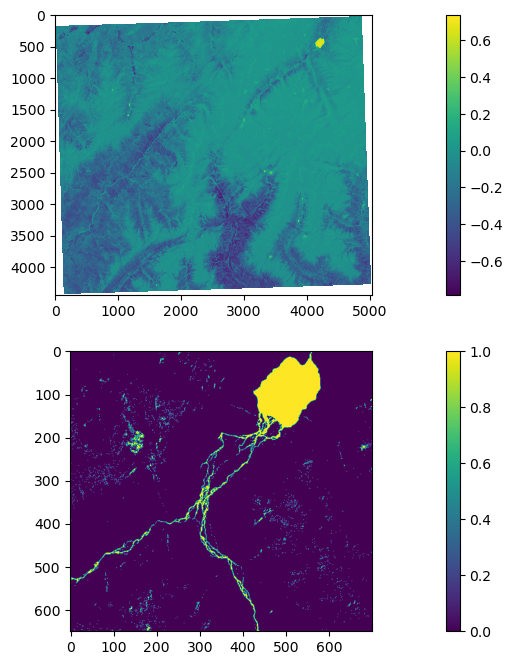

In [186]:
flood_px3 = ((array3) > t_NDWI_otsu)# & (pw_px == 0) 
print('Global threshold based on K&I algorithm: '+str(t_NDWI_KI))
print('Global threshold based on Otsu algorithm: '+str(t_NDWI_otsu))

fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,figsize=(19,8))
img1=ax.imshow(array3)
#img2=ax1.imshow(flood_px)
img2=ax1.imshow(flood_px3[350:1000,3700:4400])
fig.colorbar(img1, ax=ax)
fig.colorbar(img2, ax=ax1)

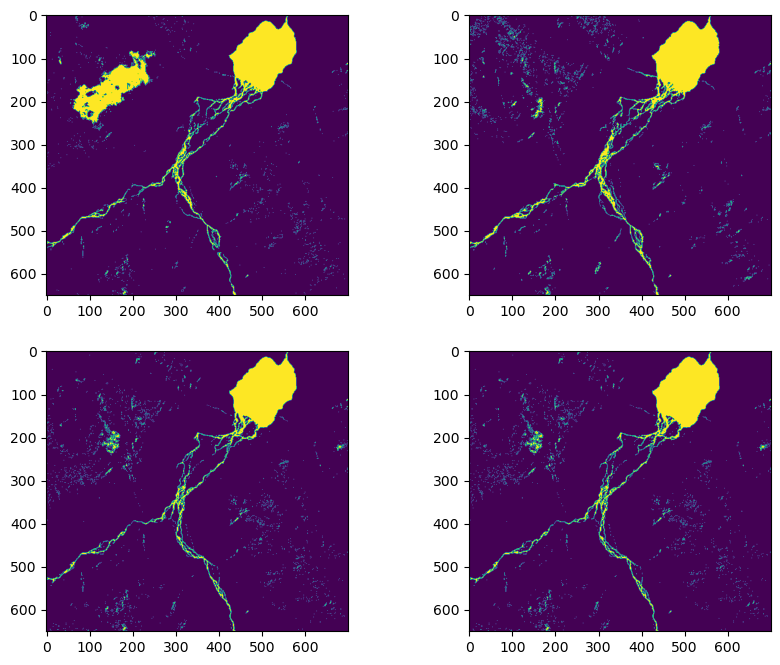

In [195]:
fig,(((ax),(ax1)),((ax2),(ax3)))=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
ax.imshow(flood_px[350:1000,3700:4400])
ax1.imshow(flood_px1[350:1000,3700:4400])
ax2.imshow(flood_px2[350:1000,3700:4400])
ax3.imshow(flood_px3[350:1000,3700:4400])

In [ ]:
fig,(((ax),(ax1)),((ax2),(ax3)))=plt.subplots(nrows=2,ncols=2,figsize=(19,8))
ax.imshow(flood_px)
ax1.imshow(flood_px1)
ax2.imshow(flood_px2)
ax3.imshow(flood_px3)

In [196]:
flood_px2==flood_px3

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])